# Training and playing in Gfootball environment Reainforcement Learning

## Setting up Gfootball in Google Colab
It is currently without render option, calling render will cause error!

In [1]:
!apt-get update
!apt-get install libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v2.8 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.6.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libs

Creating environment and trying some basic testing in the environment

In [2]:
import gfootball.env as football_env
env = football_env.create_environment(env_name="11_vs_11_stochastic", # academy_empty_goal_close
                                      rewards='checkpoints,scoring', # space between them is not allowed!
                                      stacked=False, 
                                      logdir='/tmp/football', 
                                      write_goal_dumps=False, 
                                      write_full_episode_dumps=False, 
                                      render=False)

env.reset()
steps = 0
while True:
  obs, rew, done, info = env.step(env.action_space.sample())
  steps += 1
  if steps % 100 == 0:
    print("Step %d Reward: %f" % (steps, rew))
  if done or steps>200:
    break

print("Steps: %d Reward: %.2f" % (steps, rew))

Step 100 Reward: 0.000000
Step 200 Reward: 0.000000
Steps: 201 Reward: 0.00


## Basic setup for PFRL library
* PFRL library can be found at: https://github.com/pfnet/pfrl
* The library uses pytorch models and have a high level Rainbow DQN implementation.
> Rainbow DQN performed extremely well in many atari games on pixel input, so i am assuming it will work in SMM representation as well.
> * You can read paper at: https://arxiv.org/pdf/1710.02298.pdf

Some of the code used in this notebook is taken from kaggle competition notebook. 

---

https://www.kaggle.com/kuto0633/gfootball-rainbow-dqn-pfrl

In [3]:
!pip install pfrl==0.1.0

In [4]:
!pip show torch

Name: torch
Version: 1.7.0+cu101
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, typing-extensions, future, dataclasses
Required-by: torchvision, torchtext, pfrl, fastai


Check if we have GPU

In [5]:
import torch
# Check we can use GPU
print(torch.cuda.is_available())

if torch.cuda.is_available(): 
    # GPU id starting from 0
    gpu = 0
else:
    gpu = -1 # it will use only CPU

True


Init Logger

In [6]:
from logging import getLogger, StreamHandler, FileHandler, DEBUG, INFO

# set logger
def logger_config():
    logger = getLogger(__name__)
    handler = StreamHandler()
    handler.setLevel("DEBUG")
    logger.setLevel("DEBUG")
    logger.addHandler(handler)
    logger.propagate = False

    filepath = './result.log'
    file_handler = FileHandler(filepath)
    logger.addHandler(file_handler)
    return logger

logger = logger_config()

Seed every random seed value

In [7]:
from pfrl import utils
import random
import numpy as np

def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    utils.set_random_seed(seed)  # for PFRL
    
seed = 5046
seed_everything(seed)

# Set different random seeds for train and test envs.
train_seed = seed
test_seed = seed + 100

## Creating Environment Wrapper(s)
Read about Wrappers and their use at:
https://alexandervandekleut.github.io/gym-wrappers/

In [8]:
env.observation_space.shape

(72, 96, 4)

In [9]:
import gym
import cv2
from gym import spaces

# I modified only the observation (resize and transpose channel order)
class TransEnv(gym.ObservationWrapper):
    def __init__(self, env, channel_order="hwc"):

        gym.ObservationWrapper.__init__(self, env)
        self.height = 84
        self.width = 84
        self.ch = env.observation_space.shape[2]
        shape = {
            "hwc": (self.height, self.width, self.ch),
            "chw": (self.ch, self.height, self.width),
        }
        self.observation_space = spaces.Box(
            low=0, high=255, shape=shape[channel_order], dtype=np.uint8
        )
        

    def observation(self, frame):
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame.reshape(self.observation_space.low.shape)

In [10]:
import pfrl

def make_env(test, epsilon):   

    env = football_env.create_environment(
      env_name='11_vs_11_easy_stochastic',  # easy mode
      stacked=False,
      representation='extracted',  # SMM
      rewards='checkpoints,scoring', # space between them is not allowed!
      write_goal_dumps=False,
      write_full_episode_dumps=False,
      render=False,
      write_video=False,
      dump_frequency=1,
      logdir='/tmp/football',
      extra_players=None,
      number_of_left_players_agent_controls=1,
      number_of_right_players_agent_controls=0
    )

    # Using Observation Wrapper
    env = TransEnv(env, channel_order="chw")

    # Use different random seeds for train and test envs
    env_seed = test_seed if test else train_seed
    env.seed(env_seed)
    
    # If rand call is smaller than random_fraction, it acts random.
    env = pfrl.wrappers.RandomizeAction(env, random_fraction=epsilon)

    return env

env = make_env(test=False, epsilon = 0.1) # take random action with 0.1 probability - epsilon greedy
eval_env = make_env(test=True, epsilon = 0) # Evaluate on greedy policy

print('Observation space:', env.observation_space.low.shape)
print('Action space:', env.action_space)

Observation space: (4, 84, 84)
Action space: Discrete(19)


We can see above that the observation space changed according to our ObservationWrapper

Testing the Wrapped environment:

In [11]:
env.reset()
action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs.shape)
print('reward:', r)
print('done:', done)
print('info:', info)

next observation: (4, 84, 84)
reward: 0.0
done: False
info: {'score_reward': 0}


## Create the model

Making a DistributionalDuelingDQN

In [12]:
from pfrl.q_functions import DistributionalDuelingDQN

obs_n_channels = env.observation_space.low.shape[0] # 4 channels for SMM
n_actions = env.action_space.n # 19 for Gfootball
print("obs_n_channels: ", obs_n_channels)
print("n_actions: ", n_actions)

# params based the original paper
n_atoms = 51
v_max = 10
v_min = -10
q_func = DistributionalDuelingDQN(n_actions, n_atoms, v_min, v_max, obs_n_channels)
print(q_func)

obs_n_channels:  4
n_actions:  19
DistributionalDuelingDQN(
  (conv_layers): ModuleList(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (main_stream): Linear(in_features=3136, out_features=1024, bias=True)
  (a_stream): Linear(in_features=512, out_features=969, bias=True)
  (v_stream): Linear(in_features=512, out_features=51, bias=True)
)


Replay Buffer and optimizer hyperparameters

In [13]:
from pfrl import nn as pnn
from pfrl import replay_buffers
from pfrl import explorers

# Noisy nets
pnn.to_factorized_noisy(q_func, sigma_scale=0.5)


def random_action_func():
    return env.action_space.sample()
# Turn off explorer
# explorer = explorers.Greedy()
explorer = explorers.ConstantEpsilonGreedy(epsilon=0.05, random_action_func=random_action_func)
# Trying out Decaying Epsiolon algorithms with bigger training loops could be nice idea

# Use the same hyper parameters as https://arxiv.org/abs/1710.02298
opt = torch.optim.Adam(q_func.parameters(), 6.25e-5, eps=1.5 * 10 ** -4)

# Prioritized Replay Buffer
# Anneal beta from beta0 to 1 throughout training
update_interval = 4
betasteps = 2e7 # default value: betasteps=2e5 
rbuf = replay_buffers.PrioritizedReplayBuffer(
        10 ** 6,  # Default value is 10 ** 6
        alpha=0.5,
        beta0=0.4,
        betasteps=betasteps, # default value: betasteps=2e5 
        num_steps=3,
        eps=0.01,
        normalize_by_max="memory",
    )


def phi(x):
    # Feature extractor
    return np.asarray(x, dtype=np.float32) / 255

Agent hyperparameters

In [14]:
from pfrl.agents import CategoricalDoubleDQN

replay_start_size = 50000 # default 50000

agent = CategoricalDoubleDQN(
        q_function=q_func,
        optimizer=opt,
        replay_buffer=rbuf,
        gpu=gpu,  
        gamma=0.99,
        explorer=explorer,
        minibatch_size=32,
        replay_start_size=replay_start_size,
        target_update_interval=10000,
        update_interval=update_interval,
        batch_accumulator="sum",
        phi=phi,
    )

Load previous model if there are any


---


Using the Best previous weight is like an early stopping method

Hint: Sometimes loading model or training fails due to some error. The error seems to be pytorch related, restarting the runtime and running the cells again solves the issue.

In [15]:
outputdir="./agents/agent"


use_pretrained = True
pretrained_path = "./agents/agent/best"
pretrained_path = "./actual_state"

if use_pretrained:
    agent.load(pretrained_path)


In [16]:
try:
    print(agent.loss_record.pop())
except:
    print('No loss record')

No loss record


## Training the model

In [ ]:
from pfrl import experiments
import torch


def train():
    experiments.train_agent_with_evaluation(
        agent=agent,
        env=env,
        steps=121100,
        eval_n_steps=None,
        eval_n_episodes=50,
        eval_interval=20000,
        outdir=outputdir,
        save_best_so_far_agent=True,
        eval_env=eval_env,
        logger=getLogger()
    )

%time train()

Code for saving the best model locally. It makes a zip file, which can be downloaded.

In [ ]:
#!zip -r ./model.zip ./agents/agent/best
!zip -r ./model2.zip ./actual_state

  adding: actual_state/ (stored 0%)
  adding: actual_state/model.pt (deflated 54%)
  adding: actual_state/target_model.pt (deflated 54%)
  adding: actual_state/optimizer.pt (deflated 44%)


Save the model

In [46]:
agent.save('actual_state')


## Evaluation

### Appending and evaluating results manually

In [42]:
from pfrl import experiments

print(agent.get_statistics())
# agent.save('actual_state')

# Turn of exploration with Greedy algorithm
agent.explorer = explorers.Greedy()
stats = experiments.eval_performance(eval_env,agent,None, 10, 1000,logger)
# Set back if we training further
agent.explorer = explorers.ConstantEpsilonGreedy(epsilon=0.05, random_action_func=random_action_func)

print(stats)

[('average_q', nan), ('average_loss', 118.01401710510254), ('cumulative_steps', 133200), ('n_updates', 20800), ('rlen', 133198)]


evaluation episode 0 length:1000 R:-0.7999999970197678
evaluation episode 1 length:1000 R:0.0
evaluation episode 2 length:1000 R:0.10000000149011612
evaluation episode 3 length:1000 R:0.0
evaluation episode 4 length:1000 R:-0.7999999970197678
evaluation episode 5 length:1000 R:-0.6999999955296516
evaluation episode 6 length:1000 R:-0.29999998211860657
evaluation episode 7 length:1000 R:0.10000000149011612
evaluation episode 8 length:1000 R:-2.899999998509884
evaluation episode 9 length:1000 R:-0.7999999970197678


{'episodes': 10, 'mean': -0.6099999964237213, 'median': -0.4999999888241291, 'stdev': 0.8949860336769715, 'max': 0.10000000149011612, 'min': -2.899999998509884}


In [43]:
import csv
columns = ['episodes', 'mean', 'median', 'stdev', 'max', 'min']
from os import path

filename = 'manualscore.txt'
if path.exists(filename):
    with open(filename, 'a') as f:
        writer = csv.DictWriter(f, fieldnames=columns)
        writer.writerow(stats)
else:    
    with open(filename, 'w') as f:
        writer = csv.DictWriter(f, fieldnames=columns)
        writer.writeheader()
        writer.writerow(stats)

In [39]:
import pandas as pd
scores = pd.read_csv(filename, sep=',')
scores.tail(5)

,episodes,mean,median,stdev,max,min
0,1,0.5,0.5,0.0,0.5,0.5
1,1,0.5,0.5,0.0,0.5,0.5
2,1,0.5,0.5,0.0,0.5,0.5
3,1,0.5,0.5,0.0,0.5,0.5


4
[0 1 2 3]


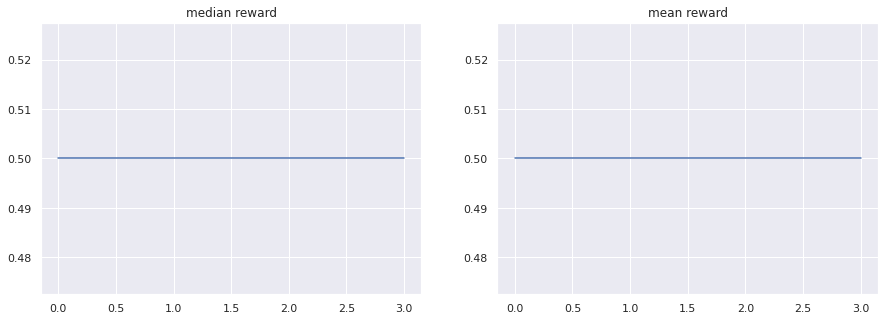

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualize reward each episodes
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title("median reward")
ax2.set_title("mean reward")
print(scores.count()[0])
x = np.arange(0, scores.count()[0], 1)
print(x)
ax1.plot(x, scores['median'])
ax2.plot(x, scores['mean'])

plt.show()

### Automatically created result from the last training session

Scores.txt shows the results of the last training session

In [44]:
import pandas as pd
scores = pd.read_csv(outputdir + "/scores.txt", sep='\t')
scores.tail(5)

,steps,episodes,elapsed,mean,median,stdev,max,min,average_q,average_loss,cumulative_steps,n_updates,rlen
35,108036,36,2760.786944,-3.6,-3.6,0.0,-3.6,-3.6,NaN,119.681240,120136,17534,120136
36,111037,37,2842.019182,-2.0,-2.0,0.0,-2.0,-2.0,NaN,118.851437,123137,18284,123137
37,114038,38,2922.802361,-2.8,-2.8,0.0,-2.8,-2.8,NaN,118.857606,126138,19034,126138
38,117039,39,3004.054122,-2.5,-2.5,0.0,-2.5,-2.5,NaN,118.859137,129139,19784,129139
39,120040,40,3084.148925,0.6,0.6,0.0,0.6,0.6,NaN,118.776547,132140,20535,132140


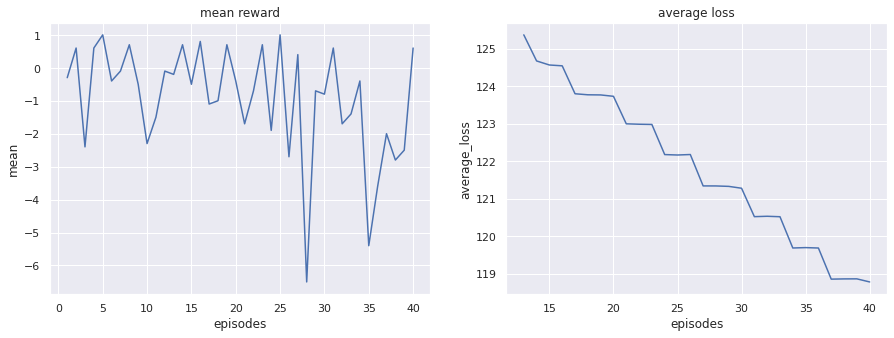

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# visualize reward each episodes
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title("mean reward")
ax2.set_title("average loss")
sns.lineplot(x="episodes", y="mean", data=scores, ax=ax1)
sns.lineplot(x="episodes", y="average_loss", data=scores,ax=ax2)
plt.show()